Импорт библиотек


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
from datetime import datetime, timedelta
import seaborn as sns # seaborn - надстройка над pyplot (она необязателена)

import it4fin_functions as it4fin # мои функции выделенные в отдельный модуль

In [2]:
# настройка для pandas для отображения всех строк и колонок
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set() # делаем графики более красивыми через seaborn


Создание соединения с базой данных

In [3]:
cnxn = psycopg2.connect(user='postgres',
                        database='postgres',
                        host='localhost',
                        port='5432',
                        password='12345')
print(cnxn.get_dsn_parameters())

# проверочный запрос
pd.read_sql_query("SELECT * FROM stock_orders LIMIT 1", cnxn)

{'user': 'postgres', 'channel_binding': 'prefer', 'dbname': 'postgres', 'host': 'localhost', 'port': '5432', 'options': '', 'sslmode': 'prefer', 'sslcompression': '0', 'sslsni': '1', 'ssl_min_protocol_version': 'TLSv1.2', 'gssencmode': 'disable', 'krbsrvname': 'postgres', 'target_session_attrs': 'any'}


,no,security_code,buysell,order_no,action,price,volume,trade_no,trade_price,order_time
0,8330055,SBER,B,4086461,2,107.84,1330,2541404003,107.84,14:35:14.135000


In [12]:
def get_spread_series(cnxn, security_code, end_time, start_time=None, freq=None):
    '''
    Основная функция для выполнения дз

    :param cnxn: соединение с базой данных
    :param security_code: тикер для ценной бумаги, например, 'AFLT'
    :param start_time: (optional) начало временного интервала, в формате 'HH:MI:SS.mss'
    :param end_time: конец временного интервала в том же формате
    :param freq: (optional), частота в миллисекундах

    :returns: `DataFrame`, определяющий биржевой стакан для ценной бумаги (buy volume - price - sell volume) и бид аск спред как `int` в слyчае заданы только `end_time` и `security_code` . Если, в добавок, даны `start_time` и `freq` то так же возвращает `Series` бид-аск спредов для временного интервала между `start_time` и `end_time`

    '''

    # считываем шаблон запроса для получения таблицы
    with open('template_get_remaining_volumes.sql', 'r', encoding='utf-8') as f:
        get_remaining_volumes = f.read()

    # печатаем полученные на вход аргументы
    print(security_code, start_time, end_time)

    # дальше ветка: если нет start_time или частота нулевая
    if start_time is None or freq is None or freq == 0:
        # то формируем запрос на получение таблицы заявок до времени end_time и выполняем его
        query = get_remaining_volumes.format(security_code = security_code,
                                             time1 = '0:00:00',
                                             time2 = end_time)
        raw = pd.read_sql_query(query, cnxn)

        # превращаем эту таблицу в стакан
        dom, bid, ask = it4fin.get_dom_from_raw(raw)
        # возвращаем бид-аск спред и стакан
        return (ask - bid) * 2 / (ask + bid), dom


    # теперь когда заданы все аргументы
    # проверяем то как задан формат времени
    if '.' in start_time:
        stime = datetime.strptime(start_time, '%H:%M:%S.%f')
    else:
        stime = datetime.strptime(start_time, '%H:%M:%S')

    if '.' in end_time:
        etime = datetime.strptime(end_time, '%H:%M:%S.%f')
    else:
        etime = datetime.strptime(end_time, '%H:%M:%S')

    # создаём массивы для времени и спредов
    times, spreads = [], []

    query = get_remaining_volumes.format(security_code = security_code,
                                         time1 = '0:00:00',
                                         time2 = start_time)

    new_raw = pd.read_sql_query(query, cnxn)
    dom, bid, ask = it4fin.get_dom_from_raw(new_raw)

    # добавляем в массивы координаты
    times.append(stime)
    spreads.append((ask - bid) * 2 / (ask + bid))

    while True:
        time1 = stime
        time2 = stime + timedelta(milliseconds=freq)
        if time2 > etime:
            time2 = etime

        print(time1.strftime('%H:%M:%S.%f'), time2.strftime('%H:%M:%S.%f'))
        query = get_remaining_volumes.format(security_code = security_code,
                                             time1 = time1.strftime('%H:%M:%S.%f'),
                                             time2 = time2.strftime('%H:%M:%S.%f'))


        raw1 = new_raw
        raw2 = pd.read_sql_query(query, cnxn)

        new_raw = pd.concat([raw1, raw2], axis=0, ignore_index=True).\
                groupby(by=["buysell", "order_no", "price"], as_index=False).sum()

        dom, bid, ask = it4fin.get_dom_from_raw(new_raw)
        spreads.append((ask - bid) * 2 / (ask + bid))

        # if not raw2.empty:
        #     new_raw = pd.concat([raw1, raw2], axis=0, ignore_index=True).\
        #         groupby(by=["buysell", "order_no", "price"], as_index=False).sum()
        #
        #     dom, bid, ask = it4fin.get_dom_from_raw(new_raw)
        #     spreads.append((ask - bid) * 2 / (ask + bid))
        # else:
        #     new_raw = raw1
        #     spreads.append(spreads[-1])

        times.append(stime)
        stime = time2

        if stime == etime:
            plt.step(times, spreads, where='post')
            return (ask - bid) * 2 / (ask + bid), dom

In [9]:
# чекаем случай без спреда
bds, dom = get_spread_series(cnxn,
                             security_code='YNDX',
                             end_time='14:20:10')
print(bds)
print(dom.shape)
display(dom)

YNDX None 14:20:10
0.003163722646981401
(88, 2)


,buy,sell
price,,
1197.0,0.0,31.0
1190.3,0.0,2.0
1189.0,0.0,2.0
1173.6,0.0,10.0
1160.0,0.0,70.0
1159.9,0.0,100.0
1156.2,0.0,3.0
1155.7,0.0,1.0
1152.7,0.0,2.0


YNDX 12:00:00 14:20:10
12:00:00.000000 12:01:00.000000
12:01:00.000000 12:02:00.000000
12:02:00.000000 12:03:00.000000
12:03:00.000000 12:04:00.000000
12:04:00.000000 12:05:00.000000
12:05:00.000000 12:06:00.000000
12:06:00.000000 12:07:00.000000
12:07:00.000000 12:08:00.000000
12:08:00.000000 12:09:00.000000
12:09:00.000000 12:10:00.000000
12:10:00.000000 12:11:00.000000
12:11:00.000000 12:12:00.000000
12:12:00.000000 12:13:00.000000
12:13:00.000000 12:14:00.000000
12:14:00.000000 12:15:00.000000
12:15:00.000000 12:16:00.000000
12:16:00.000000 12:17:00.000000
12:17:00.000000 12:18:00.000000
12:18:00.000000 12:19:00.000000
12:19:00.000000 12:20:00.000000
12:20:00.000000 12:21:00.000000
12:21:00.000000 12:22:00.000000
12:22:00.000000 12:23:00.000000
12:23:00.000000 12:24:00.000000
12:24:00.000000 12:25:00.000000
12:25:00.000000 12:26:00.000000
12:26:00.000000 12:27:00.000000
12:27:00.000000 12:28:00.000000
12:28:00.000000 12:29:00.000000
12:29:00.000000 12:30:00.000000
12:30:00.000000 1

,buy,sell
price,,
1197.0,0.0,31.0
1190.3,0.0,2.0
1189.0,0.0,2.0
1173.6,0.0,10.0
1160.0,0.0,70.0
1159.9,0.0,100.0
1156.2,0.0,3.0
1155.7,0.0,1.0
1152.7,0.0,2.0


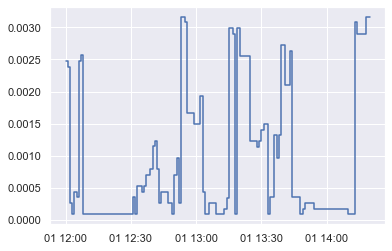

In [10]:
# чекаем случай со спердом
bds, dom = get_spread_series(cnxn,
                             security_code='YNDX',
                             start_time='12:00:00',
                             end_time='14:20:10',
                             freq=1000*60)
print(bds)
print(dom.shape)
display(dom)

YNDX 12:00:00 14:20:10
12:00:00.000000 12:01:00.000000
12:01:00.000000 12:02:00.000000
12:02:00.000000 12:03:00.000000
12:03:00.000000 12:04:00.000000
12:04:00.000000 12:05:00.000000
12:05:00.000000 12:06:00.000000
12:06:00.000000 12:07:00.000000
12:07:00.000000 12:08:00.000000
12:08:00.000000 12:09:00.000000
12:09:00.000000 12:10:00.000000
12:10:00.000000 12:11:00.000000
12:11:00.000000 12:12:00.000000
12:12:00.000000 12:13:00.000000
12:13:00.000000 12:14:00.000000
12:14:00.000000 12:15:00.000000
12:15:00.000000 12:16:00.000000
12:16:00.000000 12:17:00.000000
12:17:00.000000 12:18:00.000000
12:18:00.000000 12:19:00.000000
12:19:00.000000 12:20:00.000000
12:20:00.000000 12:21:00.000000
12:21:00.000000 12:22:00.000000
12:22:00.000000 12:23:00.000000
12:23:00.000000 12:24:00.000000
12:24:00.000000 12:25:00.000000
12:25:00.000000 12:26:00.000000
12:26:00.000000 12:27:00.000000
12:27:00.000000 12:28:00.000000
12:28:00.000000 12:29:00.000000
12:29:00.000000 12:30:00.000000
12:30:00.000000 1

,buy,sell
price,,
1197.0,0.0,31.0
1190.3,0.0,2.0
1189.0,0.0,2.0
1173.6,0.0,10.0
1160.0,0.0,70.0
1159.9,0.0,100.0
1156.2,0.0,3.0
1155.7,0.0,1.0
1152.7,0.0,2.0


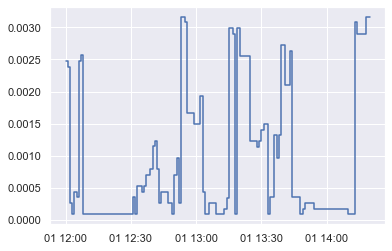

In [13]:
# чекаем случай со спердом
bds, dom = get_spread_series(cnxn,
                             security_code='YNDX',
                             start_time='12:00:00',
                             end_time='14:20:10',
                             freq=1000*60)
print(bds)
print(dom.shape)
display(dom)

In [11]:
# случай для особо умных, которые решили задать время и нулевую частоту
bds, dom = get_spread_series(cnxn,
                  security_code='YNDX',
                  start_time='12:00:00',
                  end_time='14:20:10',
                  freq=0)
print(bds)
print(dom.shape)
display(dom)

YNDX 12:00:00 14:20:10
0.003163722646981401
(88, 2)


,buy,sell
price,,
1197.0,0.0,31.0
1190.3,0.0,2.0
1189.0,0.0,2.0
1173.6,0.0,10.0
1160.0,0.0,70.0
1159.9,0.0,100.0
1156.2,0.0,3.0
1155.7,0.0,1.0
1152.7,0.0,2.0
